# PART 1

## Some Imports

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

warnings.filterwarnings('ignore')

## Read data

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train.size

In [ ]:
pyplot.imshow(X_train[3], cmap=pyplot.get_cmap('gray'))
pyplot.show()
y_train[3]

In [ ]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  ' + str(X_test.shape))
print('Y_test:  ' + str(y_test.shape))

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

In [ ]:
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm


def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def save_model():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = define_model()
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    model.save("built_models/final_model.keras")


save_model()

In [ ]:
def run_test_harness():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = load_model('built_models/final_model.keras')
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))


run_test_harness()

In [ ]:
def load_image(filename):
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    img = img_to_array(img)  # convert to array
    img = img.reshape(1, 28, 28, 1)  # reshape into a single sample with 1 channel
    img = img.astype('float32')  # prepare pixel data
    img = img / 255.0
    return img


def predict_from_image(img):
    img = img.reshape(28, 28)
    model = load_model('built_models/final_model.keras')
    predict_value = model.predict(img)

    for val in predict_value[0]:  # if you see points for each digit 
        print(format(val, '.20f'))

    digit = argmax(predict_value)
    print(digit)


def predict_from_image_path(imgPath):
    img = load_image(imgPath)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    model = load_model('built_models/final_model.keras')
    predict_value = model.predict(img)

    for val in predict_value[0]:  # if you see points for each digit 
        print(format(val, '.20f'))

    digit = argmax(predict_value)
    print(digit)

In [ ]:
predict_from_image_path('test_images/1.png')

# PART 2

In [97]:
model = tf.keras.models.load_model('built_models/final_model.keras')
optimizer = tf.keras.optimizers.Adam()

learning_rate = 0.01
num_iterations = 1000

desired_output = np.zeros((1, 10))  # desired_output = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
desired_output[0, 3] = 1  # desired_output = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


def loss_fn(y_true, y_pred):  # loss function
    return tf.reduce_mean(tf.square(y_pred - y_true))


def input_optimization(input, desired_output):
    input_image = None
    if input is None:
        input_shape = (28, 28, 1)  # 28x28 grayscele image
        input_image = 0.5 * np.random.random(input_shape) + 0.5  # random grayscale image
    else:
        input_image = load_image(input)

    for i in range(num_iterations):  # optimization
        with tf.GradientTape() as tape:
            input_tensor = tf.convert_to_tensor(input_image)  # input to tensor
            input_tensor = tf.reshape(input_tensor, (1, 28, 28, 1))
            model_output = model(input_tensor)
            loss = loss_fn(desired_output, model_output)  # compute loss

        gradients = tape.gradient(loss, input_tensor)

        if gradients is not None:  # update the inpat image
            input_image -= learning_rate * gradients.numpy()

    if input is None:
        plt.imshow(input_image, cmap='gray')
        plt.show()
        return input_image.reshape(1, 28, 28, 1)
    else:
        plt.imshow(input_image[0, :, :, 0], cmap='gray')
        return input_image[0, :, :, 0]


## Random image

In [ ]:
input_optimization(None, desired_output)

## Actual image of the digit with noise added

In [ ]:
input_optimization('test_images/3_noised.png', desired_output)

## For All Digits

In [ ]:
for i in range(10):
    desired_output = np.zeros((1, 10))  # desired_output = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    desired_output[0, i] = 1  # desired_output = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    input_optimization(None, desired_output)

## Between digits 2 and 3.

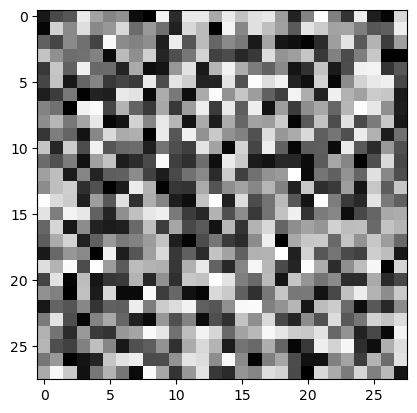

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted digit:  5


In [98]:
desired_output = np.zeros((1, 10))  # desired_output = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
desired_output[0, 2] = 0.5  # desired_output = [0, 0, 0.5, 1, 0, 0, 0, 0, 0, 0]
desired_output[0, 3] = 0.5  # desired_output = [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0]
output_image = input_optimization(None, desired_output)
# print("Predicted digit: ", argmax(model.predict(output_image)))